# Processamento de Notícias

Este notebook contém a implementação referente ao Trabalho 02 da disciplina CK0149 - Garimpagem de Dados. Consiste do tratamento de dados de notícias do arquivo news_data.xml e a aplicação de algoritmos de classificação sobre os mesmos.

* OBS: Favor utilizar o arquivo news_data.xml provido por mim. Fiz algumas alterações no dataset original, removendo algumas linhas, para facilitar a leitura.

## 1. Lendo o arquivo xml

Inicialmente usaremos o pacote xml.etree.ElementTree para ler os dados do arquivo xml.

In [1]:
# -*- coding: utf-8 -*-
from lxml import etree as ET

with open("news_data.xml", "r") as f:
    data = f.read()
    
parser = ET.XMLParser(recover=True)
tree = ET.fromstring(data, parser=parser)

Aqui vamos selecionar, dentre as tags do arquivo xml, aquelas que queremos. Dessa forma, juntaremos o título, o texto e a descrição de cada notícia para gerar o conjunto de exemplos e o atributo category para obter os labels. Ao final, faremos uma permutação dos dados e separaremos em X e y.

In [2]:
import random

news = list()
rand = list()
data_x = list()
data_y = list()
for el in tree.iterfind('.//item'):
    
    element = {}
    element.update({'category': el.attrib['category']})
    
    firstTime = True
    for title in el.iterfind('.//title'):
        if firstTime:
            element.update({'title': title.text})
            firstTime = False
    
    firstTime = True
    for description in el.iterfind('.//description'):
        if firstTime:
            element.update({'description': description.text})
            firstTime = False
            
    
    firstTime = True
    for text in el.iterfind('.//text'):
            if firstTime:
                element.update({'text': text.text})
                firstTime = False
    
    
    news.append(element)
            
for element in news:
    treatedElement = ""
    for key in element:
        if key == 'category':
            category = element[key]
        elif element[key] != None:
            treatedElement += element[key] + '\n'
    
    rand.append((treatedElement, category))

rand.pop(1)
random.shuffle(rand)
    
for pair in rand:
    data_x.append(pair[0])
    data_y.append(pair[1])

Nesse momento, temos os textos das notícias tratados dentro da lista data_x e seus respectivos labels na lista data_y

## 2. Tratamento das notícias

Agora precisamos fazer os tratamentos requisitados das strings (remoção de stopwords, stemming, tokenização e remoção da pontuação). Para isso, usaremos o NLTK.

In [3]:
import nltk
from nltk.stem.snowball import SnowballStemmer

In [4]:
stemmer = SnowballStemmer("portuguese")

stopwords = nltk.corpus.stopwords.words('portuguese')

data_x_treated = []
for element in data_x:
    tokenizedElement = nltk.word_tokenize(element)
    stemmed = [stemmer.stem(el) for el in tokenizedElement if el not in stopwords]
    data_x_treated.append(stemmed)

In [5]:
undesired = [',', '.', ';', ':', '?', '!', '"', "'", '-', "%", "(", ")", "&", "$", "+", "=", "/"]

for data in data_x_treated:
    for word in data:
        if word in undesired:
            data.remove(word)

X_full = []
for data in data_x_treated:
    text = ""
    for word in data:
        text += word + " "
    X_full.append(text)

Uma vez que fizemos esse primeiro tratamento, precisamos calcular o TF-IDF, afim de obter as features que usaremos na classificação. Para isso, usaremos o scikit-learn, uma vez que os classificadores usam dados em um formato específico que é fornecido por ele.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_vectorized = count_vect.fit_transform(X_full)

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_operator = TfidfTransformer(use_idf=False).fit(X_vectorized)
X = tf_operator.transform(X_vectorized)

Agora estamos prontos para aplicar os classificadores

## 3. Classificação

Para a classificação, inicialmente devemos separar os dados em treino e teste

In [8]:
sep = int(0.67*X.shape[0])

X_train = X[:sep]
X_test = X[sep:]

y_train = data_y[:sep]
y_test = data_y[sep:]

X_train.shape

(1413, 19825)

Agora, vamos iniciar o processo de classificação. Aplicaremos os seguintes classificadores:
* Regressão logística pelo método dos mínimos quadrados
* K-Vizinhos mais próximos (com K = 3)
* Árvore de decisão
* Random Forest
* Naive Bayes Multinomial
* Multi-Layer Perceptron

### a) Regressão logística pelo método dos mínimos quadrados

In [9]:
from sklearn import linear_model
scores = []

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train,y_train)
scores.append(logreg.score(X_test,y_test))

### b) K-Vizinhos mais próximos

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn3 = KNeighborsClassifier(n_neighbors=4)
knn3.fit(X_train, y_train)

scores.append(knn3.score(X_test, y_test))

### c) Árvore de decisão

In [11]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier(criterion="entropy")
dTree.fit(X_train, y_train)

scores.append(dTree.score(X_test, y_test))

### d) Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

randForest = RandomForestClassifier(n_estimators = 50)
randForest.fit(X_train, y_train)

scores.append(randForest.score(X_test, y_test))

### e) Naive Bayes Multinomial

In [13]:
from sklearn.naive_bayes import MultinomialNB

multinomialNB = MultinomialNB()
multinomialNB.fit(X_train, y_train)
scores.append(multinomialNB.score(X_test, y_test))

### f) Multi-Layer Perceptron

In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(19, 20), random_state=1)
mlp.fit(X_train, y_train)
scores.append(mlp.score(X_test, y_test))

## 4. Gráficos

Para discutir os resultados, alguns gráficos serão plotados.

### a) Scores por classificador

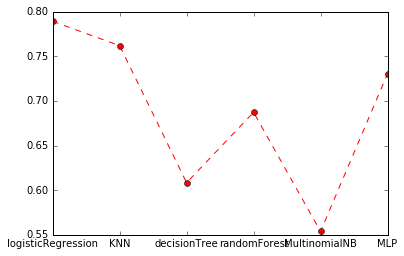

In [15]:
import matplotlib.pyplot as plt

xticks = ['logisticRegression', 'KNN', 'decisionTree', 'randomForest', 'MultinomialNB', 'MLP']
x = range(6)
plt.xticks(x, xticks)
plt.plot(x, scores, 'ro--')
plt.show()


Como podemos ver, os classificadores que obtiveram os maiores scores para esse dataset foram o método dos mínimos quadrados e o KNN.

### b) KNN: score em função do valor de $K$

Uma análise interessante a ser feita é a acurácia do KNN em função do valor de $K$.

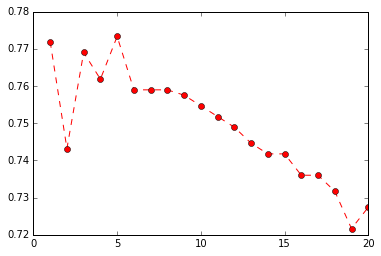

In [16]:
knnscores = []
for k in range(20):
    knn = KNeighborsClassifier(n_neighbors=(k+1))
    knn.fit(X_train, y_train)
    knnscores.append(knn.score(X_test, y_test))

x = [i + 1 for i in range(20)]
plt.plot(x, knnscores, 'ro--')
plt.show()

Aqui podemos ver que o KNN obtém resultados muito bons em relação aos outros classificadores mesmo ao variar o valor de $K$. Os scores obtidos variam em no máximo 0.060 entre si. Portanto é um ótimo classificador para essa situação.

### c) Random Forest: Mudando o número de estimadores

Vejamos a variação dos scores do classificador Random Forest em função do número de estimadores que utilizamos.

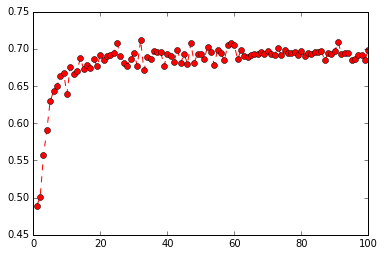

In [17]:
forestScores = []

for n_est in range(100):
    randForest = RandomForestClassifier(n_estimators = (n_est + 1))
    randForest.fit(X_train, y_train)
    forestScores.append(randForest.score(X_test, y_test))

x = [(i + 1) for i in range(100)]
plt.plot(x, forestScores, 'ro--')
plt.show()

Aqui vemos um resultado muito interessante: Mesmo que dobremos o numero de classificadores que usamos no classificador da seção 1.3.4 (no caso 50), o score obtido não será muito melhor. Os scores tendem para um valor próximo de 70% quando aumentamos o número de estimadores.

### d) MLP: Análises em relação as camadas ocultas

Um grande desafio no design de redes neurais é na escolha do número de camadas ocultas que serão usadas e o número de neurônios nelas contidas. Mesmo que o MLP tenha performance bem menor que KNN ou mínimos quadrados, essa análise pode nos dizer muito sobre esses classificadores. Aqui vamos inicialmente variar o número de camadas ocultas (mantendo 20 neurônios para cada), para ter um comparativo de scores obtidos.

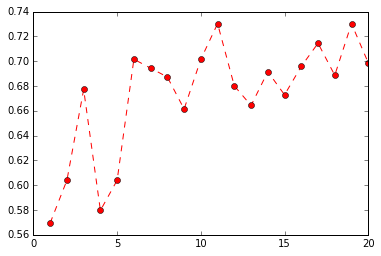

In [19]:
mlpscores = []

for n_layers in range(20):
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n_layers + 1, 20), random_state=1)
    mlp.fit(X_train, y_train)
    mlpscores.append(mlp.score(X_test, y_test))

x = [i + 1 for i in range(20)]
plt.plot(x, mlpscores, 'ro--')
plt.show()

Podemos ver que os resultados parecem não se dispor em nenhum padrão em função do número de camadas ocultas, inicialmente variando bastante mas depois se se tornando próximos da marca de 0,70. Por isso, tomemos o número de camadas que obteve o melhor resultado (no caso, 19) e variemos o número de neurônios por camada.

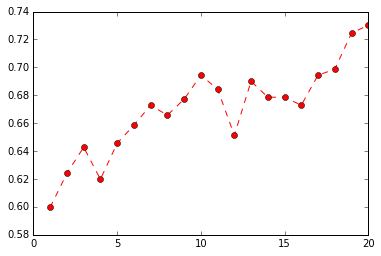

In [20]:
mlpscores = []

for n_neurons in range(20):
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(19, n_neurons + 1), random_state=1)
    mlp.fit(X_train, y_train)
    mlpscores.append(mlp.score(X_test, y_test))

x = [i + 1 for i in range(20)]
plt.plot(x, mlpscores, 'ro--')
plt.show()

Vemos aqui que o número de neurônios por camada oculta também varia os scores de maneira desordenada, os quais porém parecem tender para um valor comum quando aumentamos a quantidade de neurônios.